<a href="https://colab.research.google.com/github/EgwuSamuel/MaizeDiseasesDetector/blob/MaizeDisease/Maize_Leaf_Virus_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

  Using cached ultralytics-8.3.113-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.

In [ ]:
# Step 1: Download the dataset from Kaggle
!pip install -q kaggle

# Step 2: Set up Kaggle API Key (upload kaggle.json here in Colab for access)
from google.colab import files
files.upload()  # Upload kaggle.json file

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset
!unzip corn-or-maize-leaf-disease-dataset.zip -d maize_leaf_data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
Archive:  corn-or-maize-leaf-disease-dataset.zip
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1).jpeg  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1).jpg  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (10).jpg  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (100).jpg  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1000).JPG  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1001).JPG  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1002).JPG  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1003).JPG  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1004).JPG  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1005).JPG  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1006).JPG  
  inflating: maize_leaf_data/data/Blight/Corn_Blight (1007).JPG  
  inflat

In [ ]:
import os
import shutil
import random
from glob import glob
from PIL import Image

# Step 1: Define paths and create necessary folders
base_dir = 'maize_leaf_data/data'
output_dir = 'maize_leaf_data_prepared'
os.makedirs(output_dir, exist_ok=True)

# Create folders for train, val, and test, each with images and labels subfolders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, 'labels'), exist_ok=True)

# Step 2: Map class folders to class IDs
class_folders = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
class_mapping = {folder: i for i, folder in enumerate(class_folders)}
print("Class Mapping:", class_mapping)

# Step 3: Prepare data for each class and split into train, val, test
for class_folder, class_id in class_mapping.items():
    images = glob(os.path.join(base_dir, class_folder, '*.jpg'))
    random.shuffle(images)

    # Split into 70% train, 15% val, 15% test
    train_split = int(0.7 * len(images))
    val_split = int(0.85 * len(images))

    splits = {
        'train': images[:train_split],
        'val': images[train_split:val_split],
        'test': images[val_split:]
    }

    # Process images for each split
    for split, split_images in splits.items():
        for img_path in split_images:
            img_name = os.path.basename(img_path)

            # Copy image to the appropriate images folder
            shutil.copy(img_path, os.path.join(output_dir, split, 'images', img_name))

            # Generate label file with entire image as bounding box
            with Image.open(img_path) as img:
                width, height = img.size

            # YOLO format bounding box covering the whole image
            x_center, y_center = 0.5, 0.5
            box_width = box_height = 1.0  # Normalized values for entire image

            # Create corresponding label file
            label_path = os.path.join(output_dir, split, 'labels', f"{os.path.splitext(img_name)[0]}.txt")
            with open(label_path, 'w') as f:
                f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

print("Data preparation complete. Check 'maize_leaf_data_prepared' folder.")


Class Mapping: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
Data preparation complete. Check 'maize_leaf_data_prepared' folder.


In [ ]:
import os

# Define paths to each split
train_images_dir = os.path.join(output_dir, 'train', 'images')
val_images_dir = os.path.join(output_dir, 'val', 'images')
test_images_dir = os.path.join(output_dir, 'test', 'images')

# Function to count files in a directory
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith('.jpg')])

# Count images in each folder
train_count = count_images(train_images_dir)
val_count = count_images(val_images_dir)
test_count = count_images(test_images_dir)

print(f"Number of images in train folder: {train_count}")
print(f"Number of images in val folder: {val_count}")
print(f"Number of images in test folder: {test_count}")


Number of images in train folder: 1158
Number of images in val folder: 248
Number of images in test folder: 252


In [ ]:
# Assuming the dataset is located in the current directory
dataset_path = os.path.join(os.getcwd(), "maize_leaf_data_prepared")

# Update the number of classes and class names based on your dataset
number_of_classes = len(class_mapping)
class_names = [label for label in class_mapping.keys()]

data_yaml = f"""
path: {dataset_path}
train: {os.path.join(dataset_path, 'train/images')}
val: {os.path.join(dataset_path, 'val/images')}
test: {os.path.join(dataset_path, 'test/images')}

nc: {number_of_classes}
names: {class_names}
"""

# Save the data.yaml file
with open('data.yaml', 'w') as f:
    f.write(data_yaml.format(number_of_classes=number_of_classes, class_names=class_names))

!cat data.yaml


path: /content/maize_leaf_data_prepared
train: /content/maize_leaf_data_prepared/train/images
val: /content/maize_leaf_data_prepared/val/images
test: /content/maize_leaf_data_prepared/test/images

nc: 4
names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
from ultralytics import YOLO

models = ["yolov8n", "yolov10n", "yolov11n"]

for model_name in models:
  # Load a model
  model = YOLO(model_name)

  # Train the model
  train_results = model.train(
      data='data.yaml',
      epochs=10,
      device=0,
      name=f'{os.path.splitext(model_name)[0]}_results'
  )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.59M/5.59M [00:00<00:00, 344MB/s]


Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchs

100%|██████████| 755k/755k [00:00<00:00, 137MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

YOLOv10n summary: 223 layers, 2,708,600 parameters, 2,708,584 gradients, 8.4 GFLOPs

Transferred 493/595 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 375MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 17.8±19.5 MB/s, size: 28.4 KB)


train: Scanning /content/maize_leaf_data_prepared/train/labels... 1158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1158/1158 [00:01<00:00, 810.59it/s] 

train: New cache created: /content/maize_leaf_data_prepared/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.2±3.0 MB/s, size: 12.5 KB)


val: Scanning /content/maize_leaf_data_prepared/val/labels... 248 images, 0 backgrounds, 0 corrupt: 100%|██████████| 248/248 [00:00<00:00, 613.04it/s]

val: New cache created: /content/maize_leaf_data_prepared/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.76G     0.7047      12.17      2.259          6        640: 100%|██████████| 73/73 [00:30<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        248        248     0.0238          1      0.346      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.24G     0.2831       7.93      1.898          6        640: 100%|██████████| 73/73 [00:26<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

                   all        248        248      0.357      0.347      0.386      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.26G     0.2998      6.028      1.902          6        640: 100%|██████████| 73/73 [00:25<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        248        248      0.555      0.499      0.511      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.27G     0.2699      4.684      1.886          6        640: 100%|██████████| 73/73 [00:24<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all        248        248      0.432      0.562      0.508      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.29G     0.2384      3.675      1.858          6        640: 100%|██████████| 73/73 [00:23<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

                   all        248        248      0.384      0.626      0.497      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       3.3G     0.2023      2.996      1.856          6        640: 100%|██████████| 73/73 [00:24<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all        248        248      0.465      0.657      0.597      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.32G     0.1738      2.533      1.809          6        640: 100%|██████████| 73/73 [00:24<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        248        248       0.48      0.715      0.639      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.33G     0.1459      2.176      1.838          6        640: 100%|██████████| 73/73 [00:25<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

                   all        248        248      0.451      0.803      0.625      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.35G     0.1186      1.982      1.809          6        640: 100%|██████████| 73/73 [00:24<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

                   all        248        248      0.487      0.848      0.719      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.36G     0.1006      1.835      1.795          6        640: 100%|██████████| 73/73 [00:24<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

                   all        248        248      0.482       0.74        0.7        0.7



10 epochs completed in 0.081 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,948 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


                   all        248        248      0.488      0.845      0.718      0.718
                Blight         41         41      0.494          1      0.755      0.755
           Common_Rust         17         17      0.438      0.706      0.676      0.676
        Gray_Leaf_Spot         19         19      0.517      0.676      0.448      0.448
               Healthy        171        171      0.503          1      0.994      0.994
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# Evaluate model performance on the validation set
metrics = model.val()


Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,948 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 595.6±234.2 MB/s, size: 11.2 KB)


val: Scanning /content/maize_leaf_data_prepared/val/labels.cache... 248 images, 0 backgrounds, 0 corrupt: 100%|██████████| 248/248 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


                   all        248        248      0.513      0.809      0.751      0.751
                Blight         41         41      0.477      0.951      0.777      0.777
           Common_Rust         17         17      0.475      0.706      0.714      0.714
        Gray_Leaf_Spot         19         19      0.599      0.579      0.521      0.521
               Healthy        171        171      0.503          1      0.994      0.994
Speed: 4.3ms preprocess, 9.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
import os
import random

# Define the path to the test images directory
test_images_dir = '/content/maize_leaf_data_prepared/test/images'
output_file = '/content/maize_leaf_data_prepared/test_paths.txt'

# Set the number of samples you want to generate
num_samples = 100  # Adjust based on desired sample size or total number of test images

# Get all image file paths from the test images directory
all_test_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith('.jpg')]

# Randomly select the specified number of samples
selected_test_images = random.sample(all_test_images, min(num_samples, len(all_test_images)))

# Write the selected file paths to a text file
with open(output_file, 'w') as f:
    for image_path in selected_test_images:
        f.write(f"{image_path}\n")

print(f"Generated {len(selected_test_images)} test image paths and saved to {output_file}")


Generated 100 test image paths and saved to /content/maize_leaf_data_prepared/test_paths.txt



image 1/1 /content/maize_leaf_data_prepared/test/images/Corn_Health (680).jpg: 640x640 1 Healthy, 28.0ms
Speed: 6.6ms preprocess, 28.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


array([[[183, 223,   0],
        [183, 223,   0],
        [183, 223,   0],
        ...,
        [183, 223,   0],
        [183, 223,   0],
        [183, 223,   0]],

       [[183, 223,   0],
        [183, 223,   0],
        [183, 223,   0],
        ...,
        [183, 223,   0],
        [183, 223,   0],
        [183, 223,   0]],

       [[183, 223,   0],
        [183, 223,   0],
        [183, 223,   0],
        ...,
        [105, 161,  79],
        [125, 179,  69],
        [183, 223,   0]],

       ...,

       [[183, 223,   0],
        [183, 223,   0],
        [118, 179,  99],
        ...,
        [137, 202, 176],
        [147, 209, 142],
        [183, 223,   0]],

       [[183, 223,   0],
        [183, 223,   0],
        [125, 181,  72],
        ...,
        [146, 206, 140],
        [154, 212, 112],
        [183, 223,   0]],

       [[183, 223,   0],
        [183, 223,   0],
        [183, 223,   0],
        ...,
        [183, 223,   0],
        [183, 223,   0],
        [183, 223,   0]]], dtype=uint8)
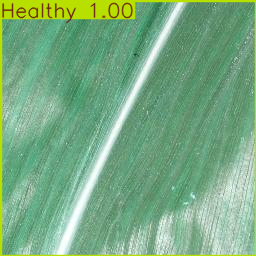

In [ ]:
import random

# Path to the test paths file (created previously)
test_paths_file = '/content/maize_leaf_data_prepared/test_paths.txt'

# Load paths from the file
with open(test_paths_file, 'r') as f:
    test_paths = f.readlines()

# Remove any trailing newlines or spaces
test_paths = [path.strip() for path in test_paths]

# Randomly select one image path
random_test_image_path = random.choice(test_paths)

# Perform object detection on an image
results = model(random_test_image_path)
results[0].plot()

In [ ]:
# Save the model after training
model.save('/content/maize_leaf_model.pt')

In [ ]:
import shutil
shutil.make_archive('/content/runs', 'zip', '/content/runs')

'/content/runs.zip'